In [32]:
import os
import sys
import urllib, io

from os import listdir
from os.path import isfile, join

import numpy as np
import scipy.stats as stats
import pandas as pd
from random import random

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import blockworld_helpers as utils


In [13]:
## directory & file hierarchy
proj_dir = os.path.abspath('../..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(proj_dir,'results')
stim_dir = os.path.join(proj_dir,'stimuli/interesting_structures')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

'/Users/will/GitHub/block_construction'

In [4]:
iterationName = 'pilot4'

# Trial_end data
trial_path = os.path.join(csv_dir,'block_silhouette_{}.csv'.format(iterationName))
df = pd.read_csv(trial_path)

# Settled_block data
settled_path = os.path.join(csv_dir,'block_silhouette_settled_{}.csv'.format(iterationName))
dfs = pd.read_csv(settled_path)

# Explore_end data
explore_path = os.path.join(csv_dir,'block_silhouette_explore_{}.csv'.format(iterationName))
dfe = pd.read_csv(explore_path)

# Exclude outliers
low_scores = df[(df.trialNum == 15) & (df.score == 0)]['gameID']

df = df[~df.gameID.isin(low_scores)]
dfs = dfs[~dfs.gameID.isin(low_scores)]
dfe = dfe[~dfe.gameID.isin(low_scores)]

n = df.gameID.nunique()
print(str(n) + ' participants with score > 0 and full set of trials')

32 participants with score > 0 and full set of trials


In [9]:
import numpy as np
from PIL import Image

from matplotlib import pylab, mlab, pyplot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.path import Path
import matplotlib.patches as patches
import copy
import json
import datetime
import random
from random import randint
import string
import os

world_size = 900;

def patch_for_block(b):
    return get_patch(b,color='#29335C')

def patches_for_world(blocks):
    patches = []
    for (b) in blocks:
        patches.append(patch_for_block(b))
    return patches

def draw_world(vertices):
    fig = render_blockworld(patches_for_world(vertices)) 
    return fig

def get_patch(verts,
              color='orange',
              line_width = 0.2):
    '''
    input:
        verts: array or list of (x,y) vertices of convex polygon. 
                last vertex = first vertex, so len(verts) is num_vertices + 1
        color: facecolor
        line_width: edge width    
    output:
        patch matplotlib.path patch object
    '''
    codes = [1] + [2]*(len(verts)-1)    ## 1 = MOVETO, 2 = LINETO
    path = Path(verts,codes)
    patch = patches.PathPatch(path, facecolor=color, lw=line_width)
    return patch

def render_blockworld(patches,
                      xlim=(0,world_size),
                      ylim=(0,world_size),
                      figsize=(4,4)):
    
    '''
    input: 
        patches: list of patches generated by get_patch() function
        xlim, ylim: axis limits
        figsize: defaults to square aspect ratio
    output:
        visualization of block placement
    '''
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    for patch in patches:
        ax.add_patch(patch)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim) 
    cur_axes = plt.gca()
    cur_axes.axes.get_xaxis().set_visible(False)
    cur_axes.axes.get_yaxis().set_visible(False)        
    #plt.show()
    return fig

def get_light_df(df_full):
    ''' Get most essential columns from dataframe
    '''
    df_light = df_full[['randID','trialNum','phase','condition','eventType','score','normedScore','numBlocks']]
    return df_light

def compress_vertices(vert_dict):
    '''
    '''
    vert_list = list(map(lambda block: list(map(lambda corner: (corner['x'],world_size-corner['y']), block)), vert_dict))
    return vert_list
    
def get_world_vertices(row):
    ''' Get vertices of this row.
    '''
    vert_dict = row['allVertices'] # extract dictionary of vertices of blocks 
    world_verts = compress_vertices(vert_dict) # convert dictionary to list of unlabelled tuples
    return world_verts

def draw_world_from_row(row):
    ''' Renders state of world from one observation
    '''
    world_verts = get_final_vertices(row)
    draw_world(world_verts)

#def draw_block_in_context(row):
    ''' draw new block in figure showing old blocks in a different color
    '''

In [ ]:
# Print all final structure for one participant
sub1 = df.head(1).gameID
dfSubjectTrials = df[df.gameID.isin(sub1)]
for i in range(0,len(dfSubjectTrials)-1):
    vert_dict = dfSubjectTrials.loc[dfSubjectTrials.trialNum == i,'allVertices'].apply(ast.literal_eval).values[0]
    vertices = compress_vertices(vert_dict)
    draw_world(vertices)

In [ ]:
df.targetName.unique()

In [ ]:
# Draw final structure for a participant
def drawFinalStructure(df, gameID, target_name):
    vert_dict = df.loc[(df.gameID == gameID) & (df.targetName == target_name),'allVertices'].apply(ast.literal_eval).values[0]
    vertices = compress_vertices(vert_dict)
    draw_world(vertices)

In [28]:
gameID = ppts[0]
df.loc[(df.gameID == gameID) & (df.targetName == target_name),'allVertices'].apply(ast.literal_eval).values[0]

[[{'x': 444.9290823724809, 'y': 592.8611021306741},
  {'x': 664.9290823401551, 'y': 592.8573306851223},
  {'x': 664.9309680629308, 'y': 702.8573306689581},
  {'x': 444.9309680952569, 'y': 702.8611021145099}],
 [{'x': 274.3366655207609, 'y': 482.5218391910096},
  {'x': 384.3365507618864, 'y': 482.3629463366975},
  {'x': 384.65433647051043, 'y': 702.3627168189452},
  {'x': 274.65445122938496, 'y': 702.5216096732569}],
 [{'x': 384.95898366799514, 'y': 483.00717856731546},
  {'x': 494.95898206966746, 'y': 482.98842671447994},
  {'x': 494.9777339225031, 'y': 592.9884251161509},
  {'x': 384.9777355208309, 'y': 593.0071769689883}],
 [{'x': 553.8928767222659, 'y': 482.9182103280854},
  {'x': 663.8924048129923, 'y': 483.240421155894},
  {'x': 663.5701939851839, 'y': 593.2399492466188},
  {'x': 553.5706658944575, 'y': 592.9177384188101}],
 [{'x': 492.7970162280978, 'y': 373.09971403671835},
  {'x': 712.7965668578886, 'y': 373.54437423322247},
  {'x': 712.574236759636, 'y': 483.5441495481178},
  

In [27]:
# draw all final structure for a given target
ppts = df.gameID.unique()
ppt = 0
gameID = ppts[ppt]
target_name = 'hand_selected_005'

for i in range(0,len(df.gameID.unique())-1):
    gameID = ppts[i]
    drawFinalStructure(df,gameID,target_name)

NameError: name 'drawFinalStructure' is not defined

In [21]:
# Draw stimuli
image_paths = [f for f in listdir(stim_dir) if isfile(join(stim_dir, f))]    
image_paths

['hand_selected_007.json',
 'hand_selected_011.json',
 'hand_selected_010.json',
 'hand_selected_006.json',
 'hand_selected_001.json',
 'hand_selected_016.json',
 'hand_selected_015.json',
 'hand_selected_003.json',
 'hand_selected_002.json',
 'hand_selected_014.json',
 'hand_selected_013.json',
 'hand_selected_005.json',
 'hand_selected_009.json',
 'hand_selected_008.json',
 'hand_selected_004.json',
 'hand_selected_012.json']

### Note to self: Stimulus files are in integer version. Will need to go into coding of experiment and see how I've converted these, and grab the values from display of stimuli.

<Figure size 1440x1440 with 0 Axes>

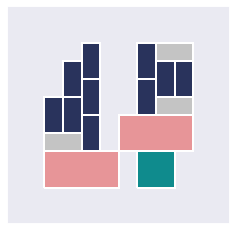

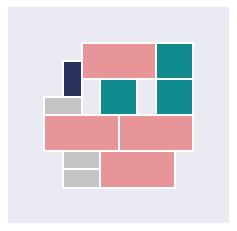

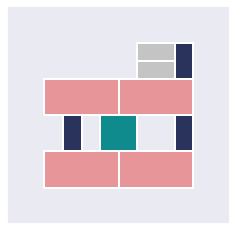

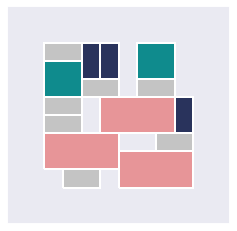

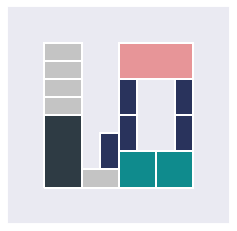

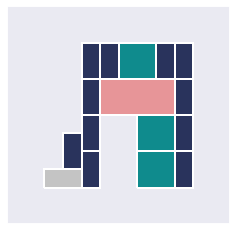

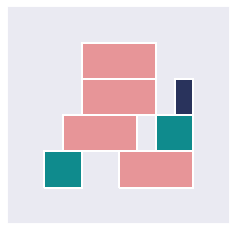

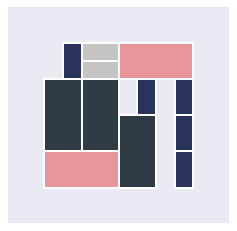

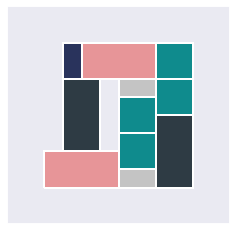

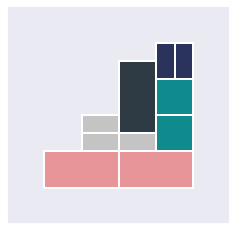

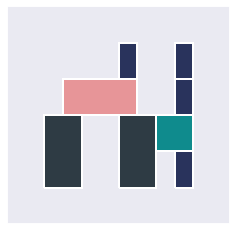

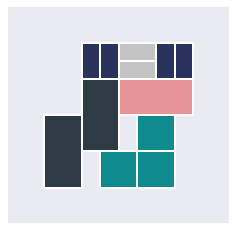

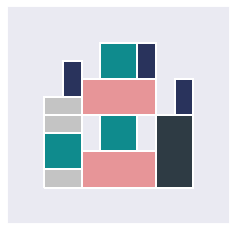

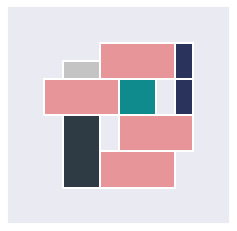

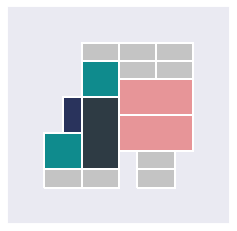

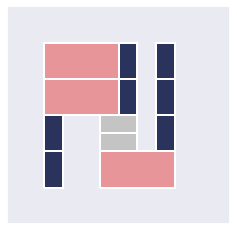

In [38]:
fig=plt.figure(figsize=(20, 20))
columns = 4
rows = 4
for i in range(0, columns*rows):
    J = open(join(stim_dir,image_paths[i])).read()
    #fig.add_subplot(rows, columns, i)
    w = utils.World()
    w.populate_from_json(J)
    subfig = utils.draw_world(w)
    #fig.add_subplot(rows, columns, i)
    #plt.imshow(img)
plt.show()

In [ ]:
# Display in grid
# Attach labels